# The future of employment

How susceptible are jobs to computerisation? 

> We examine how susceptible jobs are to computerisation. To assess this, we begin by implementing a novel methodology to estimate the probability of computerisation for 702 detailed occupations, using a **Gaussian process classifier**. Based on these estimates, we examine expected impacts of future computerisation on US labour market outcomes, with the primary objective of analysing the number of jobs at risk and the relationship between an occupations probability of computerisation, wages and educational attainment.

C. Frey, M. Osborne  *The future of employment: How susceptible are jobs to computerisation?* Technological Forecasting & Social Change 114 (2017) 254–280 


First, together with a group of ML researchers, we subjectively hand-labelled 70 occupations, assigning 1 if automatable, and 0 if not. 

- For our subjective assessments, we draw upon a workshop held at the `Oxford University Engineering Sciences Department`, examining the automatability of a wide range of tasks. 

- Our label assignments were based on eyeballing the O*NET tasks and job description of each occupation. 

- The hand-labelling of the occupations was made by answering the question “Can the tasks of this job be sufficiently specified, conditional on the availability of big data, to be performed by state of the art computer-controlled equipment”. 

- Labels were assigned only to the occupations about which we were most confident.


Second, we use objective O*NET variables corresponding to the defined bottlenecks to computerisation. 

- We are interested in variables describing the level of perception and manipulation, creativity, and social intelligence required to perform it. 
- We identified **nine variables of O*NET** that describe these attributes. 
- We rely on the “level” rating which corresponds to specific examples about the capabilities required of computer-controlled equipment to perform the tasks of an occupation. 

## Computerisation bottleneck 

- **Perception and manipulation**
    - Finger dexterity [variables of O*NET]
        - The ability to make precisely coordinated movements of the fingers of one or both hands to grasp, manipulate, or assemble very small objects.
    - Manual dexterity [variables of O*NET]
        - The ability to quickly move your hand, your hand together with your arm, or your two hands to grasp, manipulate, or assemble objects.
    - Cramped work space, awkward positions  [variables of O*NET]
        - How often does this job require working in cramped work spaces that requires getting into awkward positions?
- **Creative intelligence**
    - Originality [variables of O*NET]
        - The ability to come up with unusual or clever ideas about a given topic or situation, or to develop creative ways to solve a problem.
    - Fine arts [variables of O*NET]
        - Knowledge of theory and techniques required to compose, produce, and perform works of music, dance, visual arts, drama, and sculpture.
- **Social intelligence**
    - Social perceptiveness  [variables of O*NET]
        - Being aware of others’ reactions and understanding why they react as they do.
    - Negotiation [variables of O*NET]
        - Bringing others together and trying to reconcile differences.
    - Persuasion [variables of O*NET]
        - Persuading others to change their minds or behaviour.
    - Assisting and caring for others [variables of O*NET]
        - Providing personal assistance, medical attention, emotional support, or other personal care to others such as coworkers, customers, or patients.

We tested three Gaussian process classifiers using the **GPML toolbox** (Rasmussen and Nickisch, 2010) on our data, built around exponentiated quadratic, rational quadratic and linear covariances.

- Rasmussen, C.E., Nickisch, H., 2010. Gaussian processes for machine learning (GPML) toolbox. J. Mach. Learn. Res. 11, 3011–3015.
- Rasmussen, C.E., Williams, C.K.I., 2006. Gaussian Processes for Machine Learning. MIT Press.

Having validated our approach, we proceed to use classification to predict the probability of **computerisation** for all 702 occupations. 

## GPy


The Gaussian processes framework in Python. https://github.com/SheffieldML/GPy

In [14]:
!pip install --upgrade GPy

    100% |████████████████████████████████| 1.5MB 8.2kB/s ta 0:00:016
    100% |████████████████████████████████| 71kB 25kB/s ta 0:00:0101
  Stored in directory: /Users/datalab/Library/Caches/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built paramz


In [15]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import GPy

In [24]:
# https://github.com/computational-class/ccbook/tree/master/data/jobdata.csv
df = pd.read_csv('../data/jobdata.csv')
df.head()

,Unnamed: 0,soc,Element Name,id,label,Data Value,computerization
0,0,11-1011,Assisting and Caring for Others,70,0,2.205,0.015
1,1,11-1011,"Cramped Work Space, Awkward Positions",70,0,1.415,0.015
2,2,11-1011,Fine Arts,70,0,0.915,0.015
3,3,11-1011,Finger Dexterity,70,0,2.000,0.015
4,4,11-1011,Manual Dexterity,70,0,0.000,0.015


In [139]:
data_list=list(df['Data Value'])
X=[]
for i in range(0,585,9):
    list1=data_list[i:i+9]
    X.append(list1)
X=np.array(X)

len(X)

65

In [140]:
data_list1=list(df['label'])
Y=[]
for i in range(0,585,9):
    list1=data_list1[i]
    Y.append(list1)
Y=np.array(Y)
Y=Y[:,np.newaxis]
Y[:3]

array([[0],
       [0],
       [0]])

In [141]:
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)
m.optimize(messages=False)

In [142]:
print(m)


Name : GP regression
Objective : 28.130643010540453
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  0.3113242734729479  |      +ve      |        
  rbf.lengthscale          |   3.933616340596464  |      +ve      |        
  Gaussian_noise.variance  |  0.0964434513555219  |      +ve      |        


In [143]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, roc_auc_score, accuracy_score

X1, X2, y1, y2 = train_test_split(X, Y, random_state=0,
                                  train_size=0.6, test_size = 0.4)

In [144]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(X1, y1.flatten())
y2_model = bayes.predict(X2)  
accuracy_score(y2, y2_model), roc_auc_score(y2, y2_model)

(0.8846153846153846, 0.8846153846153847)

In [150]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 400)
forest.fit(X1, y1.flatten())
y2_model = forest.predict(X2)
y2_model = [1 if i > 0.5 else 0  for i in y2_model ]
print('Accuracy score = ', accuracy_score(y2, y2_model))
print('ROC_AUC score =', roc_auc_score(y2, y2_model))

Accuracy score =  0.8461538461538461
ROC_AUC score = 0.8461538461538461


In [185]:
from sklearn.svm import SVC 
# "Support vector classifier"
X1, X2, y1, y2 = train_test_split(X, Y, random_state=0,
                                  train_size=0.6, test_size = 0.4)
svc = SVC(kernel='linear', C=1E10)
svc.fit(X1, y1.flatten())
y2_model = svc.predict(X2)
y2_model = [1 if i > 0.5 else 0  for i in y2_model ]
print('Accuracy score = ', accuracy_score(y2, y2_model))
print('ROC_AUC score =', roc_auc_score(y2, y2_model))

Accuracy score =  0.8846153846153846
ROC_AUC score = 0.8846153846153846


In [169]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [194]:
from sklearn.model_selection import cross_val_score
svc = SVC(kernel='linear', C=1E10)

def cross_validation(model):
    roc_auc= cross_val_score(model, X, Y.flatten(), scoring="roc_auc", cv = 5)
    return roc_auc

np.mean(cross_validation(svc))

0.8912698412698414

In [203]:
from sklearn.model_selection import cross_val_score
svc = SVC(kernel='rbf', C=1E10, gamma = 'auto')

def cross_validation(model):
    roc_auc= cross_val_score(model, X, Y.flatten(), scoring="roc_auc", cv = 5)
    return roc_auc

np.mean(cross_validation(svc))

0.9103174603174604

In [205]:
len(X)/5

13.0

In [213]:
X1, X2, y1, y2 = train_test_split(X, Y, random_state=0,
                                  train_size=0.6, test_size = 0.4)
m = GPy.models.GPRegression(X1,y1,kernel)#, normalizer = True)
m.optimize(messages=False)
y2_model = m.predict(X2)[0]
y2_hat = [1 if i > 0.5 else 0  for i in y2_model ]
print('Accuracy score = ', accuracy_score(y2, y2_hat))
print('ROC_AUC score =', roc_auc_score(y2, y2_hat))

Accuracy score =  0.9230769230769231
ROC_AUC score = 0.9230769230769231


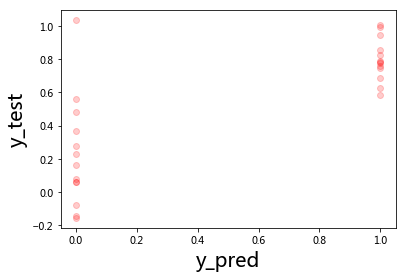

In [214]:
plt.plot(y2, y2_model, 'ro', alpha = 0.2)
plt.xlabel('y_pred', fontsize = 20)
plt.ylabel('y_test', fontsize = 20)
plt.show()

In [216]:
roc_auc_list = []
for i in range(100):
    X1, X2, y1, y2 = train_test_split(X, Y, random_state=i,
                                      train_size=0.6, test_size = 0.4)
    m = GPy.models.GPRegression(X1,y1,kernel)#, normalizer = True)
    m.optimize(messages=False)
    y2_model = m.predict(X2)[0]
    y2_hat = [1 if i > 0.5 else 0  for i in y2_model ]
    roc_auc = roc_auc_score(y2, y2_hat)
    roc_auc_list.append(roc_auc)
    
print('ROC_AUC score =', np.mean(roc_auc_list))

ROC_AUC score = 0.8779356399319636


In [217]:
roc_auc_list = []
for i in range(100):
    X1, X2, y1, y2 = train_test_split(X, Y, random_state=i,
                                      train_size=0.8, test_size = 0.2)
    m = GPy.models.GPRegression(X1,y1,kernel)#, normalizer = True)
    m.optimize(messages=False)
    y2_model = m.predict(X2)[0]
    y2_hat = [1 if i > 0.5 else 0  for i in y2_model ]
    roc_auc = roc_auc_score(y2, y2_hat)
    roc_auc_list.append(roc_auc)
    
print('ROC_AUC score =', np.mean(roc_auc_list))

ROC_AUC score = 0.8921962481962482
